# Olist Profit Optimization Plan

## 1. Problem statement (summarized)

>❓ How should Olist improve its profit margin ❓, given that it has 
> - some revenues per sellers per months
> - some revenues per orders
> - some reputation costs (estimated) per bad reviews
> - some operational costs of IT system that grows with number of orders, but not linearly (scale effects)


Our key findings so far :
- We have seen that `wait_time` was the most significant factor behind low review scores, but reading comments of the bad reviews also showed that some of them were linked to the seller or to the product itself.
- `wait_time` is made up of seller's `delay_to_carrier` + `carrier_delivery_time`. The latter being outside of Olist's direct control, improving it is not a quick-win recommendation we can make to Olist CEO without in-depth analysis of their operational practices.
- On the contrary, a better selection of `sellers` can positively impact the `delay_to_carrier` and reduce the number of bad `review_scores` on Olist.

👉 The Seller analysis is started below, followed by investigation into other hypothesis

# Should we remove underperforming sellers from our marketplace ?** 🕵🏻

To analyse the impact of removing the worse sellers from Olist's marketplace, a what-if analysis is performed: What would have happened if Olist had never accepted these sellers in the first place? (granted, it's hard to know in advance who is a good seller, but this is a good starting point).

1️⃣ For each `seller_id`, the following aspects are computed and cumulated since the beginning:
- the `revenues` it brings
- the `costs` associated with all its bad reviews
- the resulting `profits` (revenues - costs)
- the number of `orders` (it will impact the overall IT costs)


2️⃣ Then:
- sellers are sorted by increasing profits for Olist
- for each number of sellers to remove, the financial impact it would have made if they had never been accepted on the platform is computed. 
- An optimal number of sellers to remove that maximizes Olist's profit margin is then calculated

👉 A detailed strategy (step by step) is written to create the DataFrame needed for the first step.

Starting from the current `seller().get_training_data()` DataFrame, is it possible to transform the data to compute:
- Olist's positive `revenue_per_seller`?
- Olist's `cost_of_bad_reviews`?

In [2]:
#Modules are imported
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Data is imported
from seller import Seller

In [4]:
sellers = Seller().get_training_data()

sellers.head()

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews,n_orders,quantity,quantity_per_order,sales,revenues,profits
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,0.333333,0.333333,3.00,140,3,3,1.000,218.70,341.870,201.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,0.050000,0.725000,4.55,240,40,41,1.025,11703.07,2290.307,2050.307
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,0.000000,1.000000,5.00,0,1,1,1.000,158.00,15.800,15.800
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,0.000000,1.000000,5.00,0,1,1,1.000,79.99,7.999,7.999
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1.000000,0.000000,1.00,100,1,1,1.000,167.99,16.799,-83.201


In [5]:
sellers["profits"].sum()

1167608.4440000001

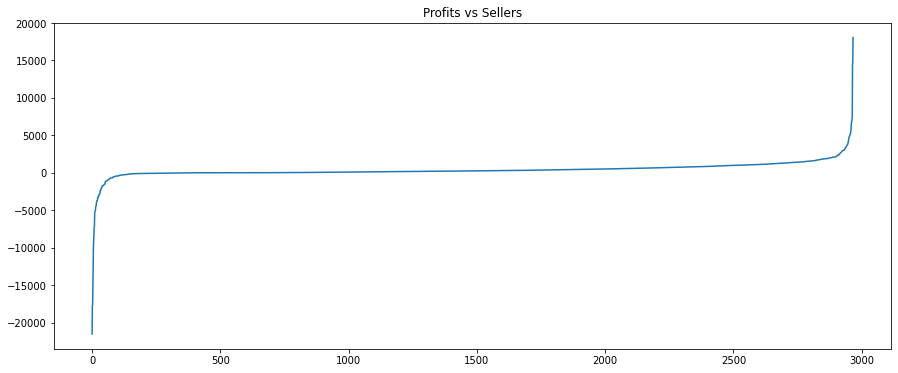

In [8]:
sellers_by_profits = sellers.sort_values(by = "profits")["profits"].reset_index()

plt.figure(figsize = (15, 6))
plt.plot(sellers_by_profits.index, sellers_by_profits["profits"])
plt.title("Profits vs Sellers");

In [4]:
sellers["n_orders"].sum()

99841

In [5]:
a = 500000/(sellers["n_orders"].sum()**0.5)
a

1582.3973364219244

In [6]:
factor1 = 500000 / (sellers["n_orders"]** 0.5).sum()

In [7]:
sellers1 = sellers.copy()

sellers1["it_costs"] = sellers1["n_orders"]** 0.5 * factor1
sellers1["profits"] = sellers1["profits"] - sellers1["it_costs"]

sellers1
sellers1["profits"].sum()

667608.444

In [9]:
sellers1[sellers1["profits"] < 0]

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews,n_orders,quantity,quantity_per_order,sales,revenues,profits,it_costs
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,0.0,1.0,5.0,0,1,1,1.0,158.00,15.800,-26.177058,41.977058
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,0.0,1.0,5.0,0,1,1,1.0,79.99,7.999,-33.978058,41.977058
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1.0,0.0,1.0,100,1,1,1.0,167.99,16.799,-125.178058,41.977058
5,c240c4061717ac1806ae6ee72be3533b,rio de janeiro,RJ,0.000000,6.056956,2018-05-08 17:55:23,2018-05-08 17:55:23,0.0,0.0,0.0,4.0,0,1,1,1.0,59.90,5.990,-35.987058,41.977058
13,05a48cc8859962767935ab9087417fbb,sao paulo,SP,0.000000,11.276516,2018-08-02 13:04:18,2018-08-02 13:04:18,0.0,0.0,1.0,5.0,0,1,1,1.0,42.90,4.290,-37.687058,41.977058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2955,e94b64dc6979b302a5a5be1662c83bb6,itapecerica da serra,SP,0.000000,9.009612,2018-07-01 12:35:14,2018-07-05 16:40:52,0.0,0.0,1.0,5.0,0,2,2,1.0,306.89,30.689,-28.675525,59.364525
2959,f00f5b35d0abcacbdd863672f4bb2c1a,sao paulo,SP,0.000000,12.155833,2017-05-27 14:25:16,2017-05-27 14:25:16,0.0,0.0,0.0,4.0,0,1,1,1.0,299.00,29.900,-12.077058,41.977058
2961,f1fdf2d13186575751aa25876536d85c,sao paulo,SP,0.000000,6.141400,2018-03-29 21:50:12,2018-03-29 21:50:12,0.0,0.0,1.0,5.0,0,1,1,1.0,26.30,2.630,-39.347058,41.977058
2962,98dddbc4601dd4443ca174359b237166,sarandi,PR,0.000000,8.230822,2018-07-14 03:10:19,2018-07-23 15:34:03,0.0,0.0,1.0,5.0,0,2,2,1.0,158.00,15.800,-43.564525,59.364525


In [10]:
sellers1[sellers1["profits"] > 0]

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews,n_orders,quantity,quantity_per_order,sales,revenues,profits,it_costs
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.0,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,0.333333,0.333333,3.000000,140,3,3,1.000000,218.70,341.870,129.163602,72.706398
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.0,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,0.050000,0.725000,4.550000,240,40,41,1.025000,11703.07,2290.307,1784.820772,265.486228
6,e49c26c3edfa46d227d5121a6b6e4d37,brejao,PE,0.0,11.653801,2017-02-04 19:31:42,2018-07-25 14:30:27,18.0,0.057143,0.742857,4.457143,330,35,36,1.028571,3654.25,1805.425,1227.085374,248.339626
7,1b938a7ec6ac5061a66a3766e0e75f90,penapolis,SP,0.0,11.376438,2017-09-23 17:24:32,2018-08-18 19:09:29,11.0,0.100000,0.600000,4.300000,300,30,33,1.100000,3987.60,1278.760,748.842182,229.917818
8,768a86e36ad6aae3d03ee3c6433d61df,sao paulo,SP,0.0,5.081859,2018-06-19 12:18:24,2018-08-24 03:15:18,2.0,0.000000,0.705882,4.647059,40,17,17,1.000000,587.46,218.746,5.670154,173.075846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2958,725af026f869236a8dd0ceb98564d156,claudio,MG,0.0,13.673095,2017-10-22 11:35:18,2018-08-04 04:10:22,9.0,0.285714,0.428571,3.428571,240,7,8,1.142857,1177.71,837.771,486.710143,111.060857
2960,7bac63f6603d382cc8d0832eb6c100a8,sao paulo,SP,0.0,15.764659,2017-11-05 09:26:15,2018-08-04 10:04:15,9.0,0.105263,0.421053,4.000000,280,19,19,1.000000,7751.95,1495.195,1032.221245,182.973755
2963,f8201cab383e484733266d1906e2fdfa,palhoca,SC,0.0,13.045797,2017-06-17 15:30:11,2018-08-11 19:55:17,14.0,0.100000,0.500000,4.100000,140,10,10,1.000000,889.00,1208.900,936.156886,132.743114
2964,74871d19219c7d518d0090283e03c137,sao paulo,SP,0.0,3.606625,2018-04-05 17:09:46,2018-08-21 19:25:15,5.0,0.000000,1.000000,5.000000,0,6,7,1.166667,550.04,455.004,352.181626,102.822374


In [11]:
sellers1[sellers1["profits"] > 0]["profits"].sum()

1112157.658369466

In [12]:
sellers2 = sellers[sellers["profits"] > 0].copy()

sum2 = (sellers2["n_orders"].sum())**0.5 * a
factor2 = sum2 / (sellers["n_orders"]** 0.5).sum()

sellers2["it_costs"] = sellers2["n_orders"]** 0.5 * factor2

sellers2["profits"] = sellers2["profits"] - sellers2["it_costs"]
sellers2

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews,n_orders,quantity,quantity_per_order,sales,revenues,profits,it_costs
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.0,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,0.333333,0.333333,3.00,140,3,3,1.000000,218.70,341.870,145.330244,56.539756
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.0,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,0.050000,0.725000,4.55,240,40,41,1.025000,11703.07,2290.307,1843.853000,206.454000
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.0,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,0.000000,1.000000,5.00,0,1,1,1.000000,158.00,15.800,-16.843244,32.643244
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.0,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,0.000000,1.000000,5.00,0,1,1,1.000000,79.99,7.999,-24.644244,32.643244
5,c240c4061717ac1806ae6ee72be3533b,rio de janeiro,RJ,0.0,6.056956,2018-05-08 17:55:23,2018-05-08 17:55:23,0.0,0.000000,0.000000,4.00,0,1,1,1.000000,59.90,5.990,-26.653244,32.643244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2962,98dddbc4601dd4443ca174359b237166,sarandi,PR,0.0,8.230822,2018-07-14 03:10:19,2018-07-23 15:34:03,0.0,0.000000,1.000000,5.00,0,2,2,1.000000,158.00,15.800,-30.364518,46.164518
2963,f8201cab383e484733266d1906e2fdfa,palhoca,SC,0.0,13.045797,2017-06-17 15:30:11,2018-08-11 19:55:17,14.0,0.100000,0.500000,4.10,140,10,10,1.000000,889.00,1208.900,965.673000,103.227000
2964,74871d19219c7d518d0090283e03c137,sao paulo,SP,0.0,3.606625,2018-04-05 17:09:46,2018-08-21 19:25:15,5.0,0.000000,1.000000,5.00,0,6,7,1.166667,550.04,455.004,375.044710,79.959290
2965,e603cf3fec55f8697c9059638d6c8eb5,pelotas,RS,0.0,6.657634,2017-02-09 02:43:17,2017-06-16 17:30:16,4.0,0.000000,0.500000,4.25,50,8,11,1.375000,297.00,349.700,207.370965,92.329035


# Removing All Non-Profit Making Sellers

In [164]:
number_1 = 0
number_2 = sellers1[sellers1["profits"] < 0].count()["seller_id"]

profit_1 = round(sellers1["profits"].sum(), 2)
profit_2 = round(sellers2["profits"].sum(), 2)

x = [number_1, number_2]
y = [profit_1, profit_2]

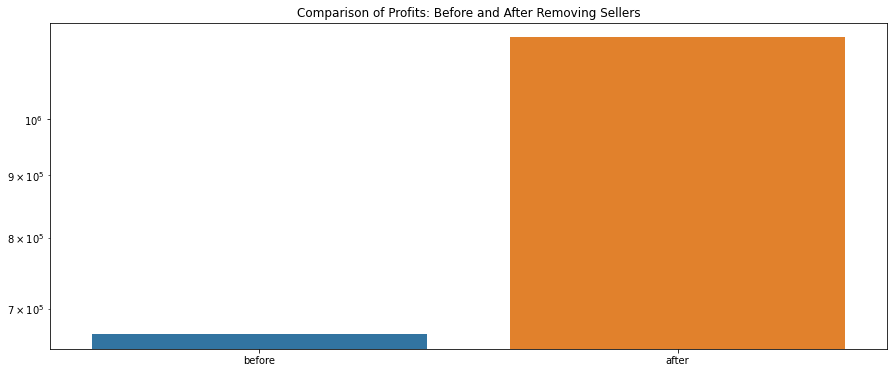

In [165]:
plt.figure(figsize = (15,6))
ax = sns.barplot(x = x, y = y)
ax.set_yscale("log")
ax.set(title = "Comparison of Profits: Before and After Removing Sellers")
ax.set(xticklabels=["before", "after"]);

In [149]:
print(f"PROFIT BEFORE REMOVAL: {profit_1}")
print(f"PROFIT AFTER REMOVAL: {profit_2}")
print(f"IMPROVEMENT: {((profit_2 - profit_1)/profit_1) * 100} %")

PROFIT BEFORE REMOVAL: 667608.444
PROFIT AFTER REMOVAL: 1166235.0375169378
IMPROVEMENT: 74.6884791524503 %


In [15]:
sellers1[sellers1["profits"] < 0]["seller_id"]

2       ce3ad9de960102d0677a81f5d0bb7b2d
3       c0f3eea2e14555b6faeea3dd58c1b1c3
4       51a04a8a6bdcb23deccc82b0b80742cf
5       c240c4061717ac1806ae6ee72be3533b
13      05a48cc8859962767935ab9087417fbb
                      ...               
2955    e94b64dc6979b302a5a5be1662c83bb6
2959    f00f5b35d0abcacbdd863672f4bb2c1a
2961    f1fdf2d13186575751aa25876536d85c
2962    98dddbc4601dd4443ca174359b237166
2966    9e25199f6ef7e7c347120ff175652c3b
Name: seller_id, Length: 1004, dtype: object

### 1.2 (optional): Here are other hypothesis you may want to investigate instead

- Should Olist remove the worst performing products / categories from its marketplace entirely?
- Should Olist remove only consistently underperforming sellers, after it has a honeymoon period of few months?
- Should Olist restrict seller/customer pairs between certain states to avoid delays?
- Should Olist acquire new sellers, with some cost assumptions to be suggested?
- ...


## Your turn!

🧺 Keep this notebook tidy! 

📅 🗣 📊 You will orally present your insights to your favorite TA at the end of this unit `Communicate`

In [16]:
from olist.data import Olist
data = Olist().get_data()

In [17]:
data.keys()

dict_keys(['sellers', 'order_reviews', 'order_items', 'customers', 'orders', 'order_payments', 'product_category_name_translation', 'products', 'geolocation'])

# Optimizing based on number of sellers to remove

In [72]:
sellers3 = sellers.sort_values(by = "profits")

In [73]:
profit = []
for i in range(len(sellers3)):
    tmp = sellers3[i:]
    it_costs = (tmp["n_orders"].sum())**0.5 * a
    total_profits = tmp["profits"].sum() - it_costs
    profit.append(total_profits)

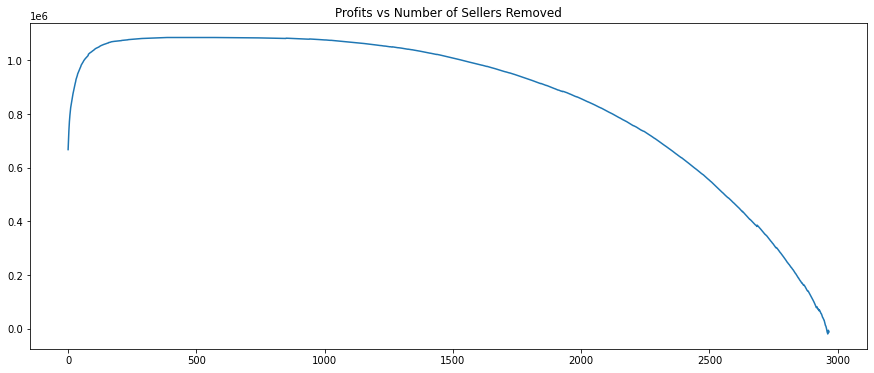

In [156]:
x = [i for i in range(len(sellers3))]
plt.figure(figsize = (15,6))
plt.plot(x, profit)
plt.title("Profits vs Number of Sellers Removed");

In [127]:
print(f"Number of sellers to remove: {profit.index(max(profit))}")

Number of sellers to remove: 486


In [75]:
profit.index(max(profit))

486

In [76]:
sellers3.iloc[487:]["profits"].sum()

1473750.469

In [123]:
number_1 = 0
number_2 = sellers1[sellers1["profits"] < 0].count()["seller_id"]
number_3 = profit.index(max(profit))

profit_1 = sellers1["profits"].sum()
profit_2 = sellers2["profits"].sum()
profit_3 = round(sellers3.iloc[487:]["profits"].sum(), 2)

x = [number_1, number_2, number_3]
y = [profit_1, profit_2, profit_3]

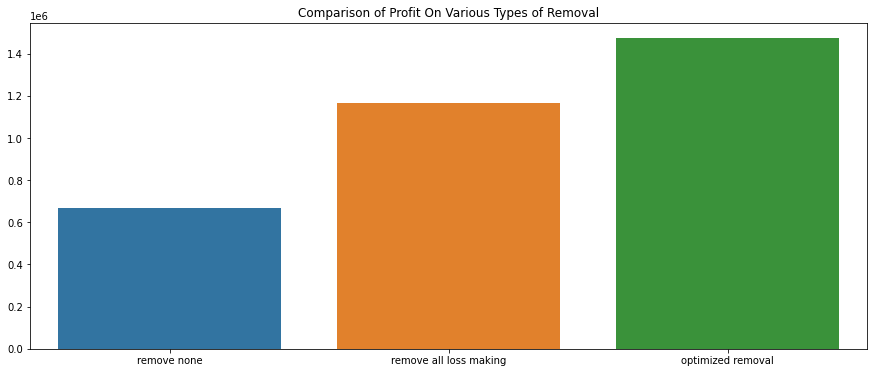

In [125]:
plt.figure(figsize = (15,6))
bx = sns.barplot(x = x, y = y, order = [number_1, number_2, number_3])
bx.set(title = "Comparison of Profit On Various Types of Removal")
bx.set(xticklabels=["remove none", "remove all loss making", "optimized removal"]);

In [150]:
print(f"Profits after removing: {profit_3}")
print(f"IMPROVEMENT: {((profit_3 - profit_1)/profit_1) * 100} %")

Profits after removing: 1473750.469
IMPROVEMENT: 120.75072330870637 %


# Optimizing Based on Months of Sellers

In [81]:
sellers5 = sellers.copy()
sellers5["months_on_olist"] = sellers5["months_on_olist"].astype("int64")

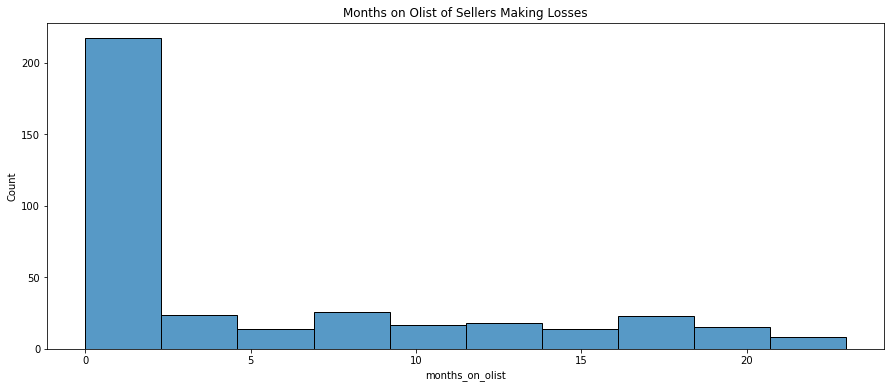

In [130]:
plt.figure(figsize = (15,6))
ex = sns.histplot(sellers[sellers["profits"] < 0]["months_on_olist"])
ex.set(title = "Months on Olist of Sellers Making Losses");

In [158]:
print("OPPORTUNITY COST ???")

OPPORTUNITY COST ???


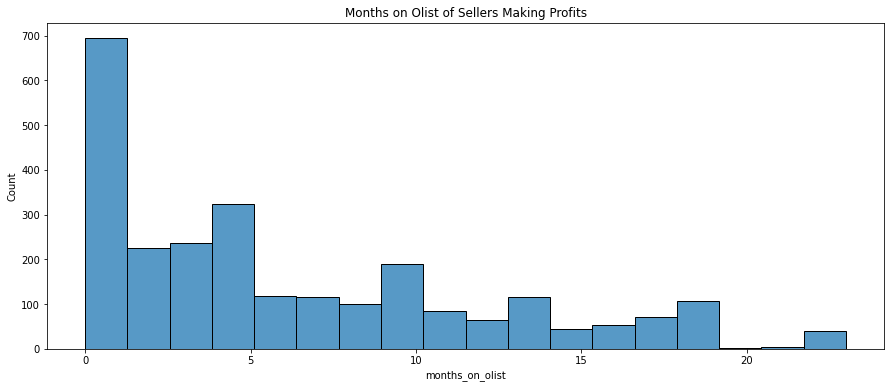

In [145]:
plt.figure(figsize = (15,6))
fx = sns.histplot(sellers[sellers["profits"] > 0]["months_on_olist"])
fx.set(title = "Months on Olist of Sellers Making Profits");

In [161]:
sellers[sellers["profits"] > 0]["months_on_olist"].median()
sellers.query("months_on_olist >= 4 and profits > 0")["profits"].mean()

918.433793728223

In [162]:
print("Months for sellers to break even: 4.0")
print("Profits per seller after break even: 918.43")

Months for sellers to break even: 4.0
Profits per seller after break even: 918.43


In [84]:
sellers6 = sellers5.query("(months_on_olist >= 4 and profits > 0) or (months_on_olist < 4)")

In [85]:
(sellers6["n_orders"].sum())**0.5 * a

392890.4899204627

In [86]:
sellers6["profits"].sum()

1453984.259

In [87]:
number_3

486

In [142]:
number_1 = 0
number_2 = sellers1[sellers1["profits"] < 0].count()["seller_id"]
number_3 = profit.index(max(profit))
number_4 = sellers5.query("months_on_olist >= 4 and profits < 0")["seller_id"].count()

profit_1 = sellers1["profits"].sum()
profit_2 = sellers2["profits"].sum()
profit_3 = sellers3.iloc[487:]["profits"].sum()
profit_4 = round(sellers6["profits"].sum(), 2)

x = [number_1, number_2, number_3, number_4]
y = [profit_1, profit_2, profit_3, profit_4]

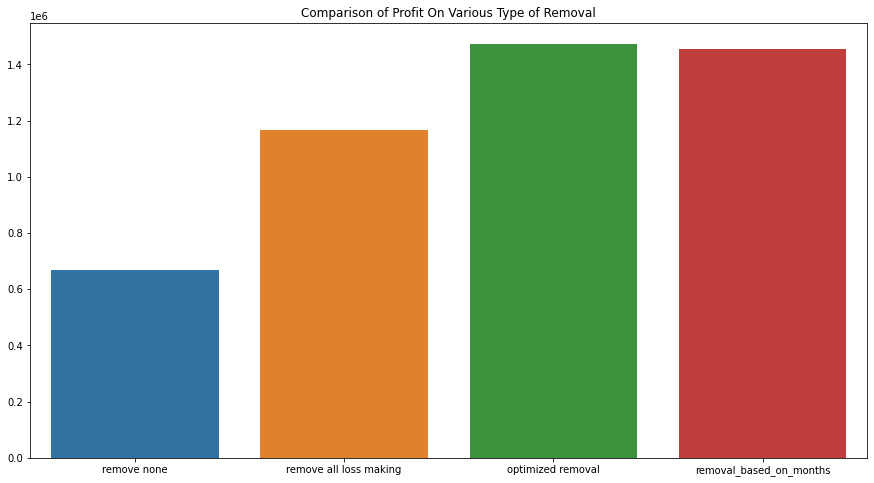

In [143]:
plt.figure(figsize = (15, 8))
cx = sns.barplot(x = x, y = y, order = [number_1, number_2, number_3, number_4])
cx.set(title = "Comparison of Profit On Various Type of Removal")
cx.set(xticklabels=["remove none", "remove all loss making", "optimized removal", "removal_based_on_months"]);

In [151]:
print(f"Number of loss making sellers after 4 months: {number_4}")
print(f"Profit after removing loss making sellers after 4 months: {profit_4}")
print(f"IMPROVEMENT: {((profit_4 - profit_1)/profit_1) * 100} %")

Number of loss making sellers after 4 months: 149
Profit after removing loss making sellers after 4 months: 1453984.26
IMPROVEMENT: 117.78997450787185 %


# Optimizing based on products

In [34]:
from olist.product import Product

In [35]:
products = Product().get_training_data()
products

,product_id,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,category,wait_time,price,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews,n_orders,quantity,sales,revenues,profits
0,1e9e8ef04dbcff4541ed26657ea517e5,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery,3.000000,10.910000,0.000000,1.000000,5.000000,0,1,1,10.91,1.091,1.091
1,6a2fb4dd53d2cdb88e0432f1284a004c,39.0,346.0,2.0,400.0,27.0,5.0,20.0,perfumery,9.500000,16.900000,0.000000,0.500000,3.500000,50,2,2,33.80,3.380,-46.620
2,0d009643171aee696f4733340bc2fdd0,52.0,150.0,1.0,422.0,21.0,16.0,18.0,perfumery,13.444444,325.627273,0.200000,0.400000,3.700000,240,10,11,3581.90,358.190,118.190
3,b1eae565a61935e0011ee7682fef9dc9,49.0,460.0,2.0,267.0,17.0,13.0,17.0,perfumery,21.000000,399.900000,0.000000,0.000000,2.000000,50,1,1,399.90,39.990,-10.010
4,8da90b37f0fb171b4877c124f965b1f6,56.0,733.0,3.0,377.0,18.0,13.0,15.0,perfumery,8.000000,137.900000,0.000000,1.000000,5.000000,0,1,1,137.90,13.790,13.790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31479,13b25797ad1e6d6c7cd3cbeb35f8ee7a,44.0,348.0,1.0,18250.0,25.0,25.0,25.0,furniture_mattress_and_upholstery,8.000000,129.900000,0.000000,0.000000,3.000000,40,1,1,129.90,12.990,-27.010
31480,dc36a7859b743d8610a2bbbaea26ece9,29.0,2073.0,2.0,2500.0,41.0,21.0,21.0,furniture_mattress_and_upholstery,6.000000,249.000000,0.000000,1.000000,5.000000,0,1,1,249.00,24.900,24.900
31481,107fde0930956120d1e13dd1062fbb46,51.0,418.0,1.0,30000.0,60.0,73.0,60.0,furniture_mattress_and_upholstery,17.000000,399.990000,0.000000,0.000000,4.000000,0,1,1,399.99,39.999,39.999
31482,726b4e18f00255e2e63491bcba3f60b8,41.0,866.0,1.0,1700.0,70.0,10.0,100.0,furniture_mattress_and_upholstery,11.818182,84.545455,0.136364,0.681818,4.272727,300,22,22,1860.00,186.000,-114.000


In [36]:
products["profits"].sum()

-289896.93499999994

In [37]:
b = 500000/(products["n_orders"].sum()**0.5)
b

1580.6804991877716

In [38]:
products1 = products.copy()

products1["it_costs"] = products1["n_orders"]** 0.5 * factor1
products1["profits"] = products1["profits"] - products1["it_costs"]

products1["profits"].sum()

-2244213.0981324026

In [39]:
products1[products1["profits"] > 0]["profits"].sum()

221172.5376493246

In [40]:
products1[products1["profits"] > 0]["product_id"].count()

2251

In [41]:
products2 = products.sort_values(by = "profits")

In [42]:
profit = []
for i in range(len(products2)):
    tmp = products2[i:]
    it_costs = (tmp["n_orders"].sum())**0.5 * a
    total_profits = tmp["profits"].sum() - it_costs
    profit.append(total_profits)

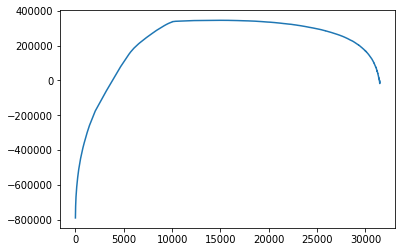

In [43]:
x = [i for i in range(len(products2))]
plt.plot(x, profit)

In [44]:
profit.index(max(profit))

14176

In [45]:
products2.iloc[profit.index(max(profit)):]["profits"].sum()

668984.81

In [46]:
number_1 = 0
number_2 = products[products["profits"] < 0].count()["product_id"]
number_3 = profit.index(max(profit))

profit_1 = products["profits"].sum()
profit_2 = products1[products1["profits"] > 0]["profits"].sum()
profit_3 = products2.iloc[profit.index(max(profit)):]["profits"].sum()

x = [number_1, number_2, number_3]
y = [profit_1, profit_2, profit_3]

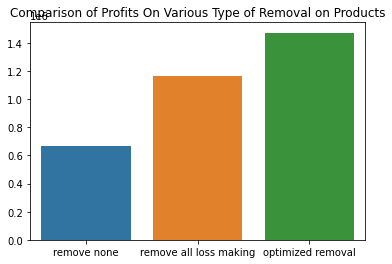

In [90]:
dx = sns.barplot(x = x, y = y, order = [number_1, number_2, number_3])
dx.set(title = "Comparison of Profits On Various Type of Removal on Products")
dx.set(xticklabels=["remove none", "remove all loss making", "optimized removal"]);

# Should Olist acquire new customers?

## Calculating by average profit per seller per month (without removal)

<AxesSubplot:xlabel='profits', ylabel='Count'>

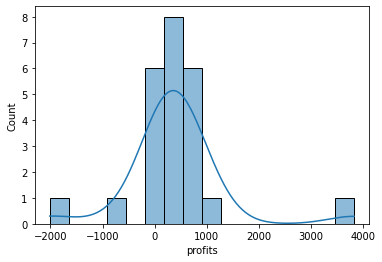

In [48]:
sns.histplot(sellers1.groupby("months_on_olist").mean()["profits"], kde = True)

<AxesSubplot:xlabel='months_on_olist', ylabel='profits'>

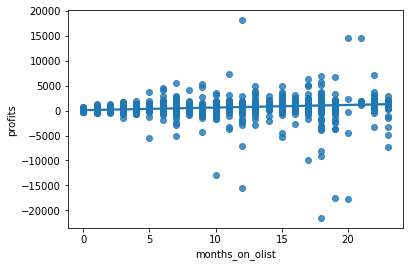

In [49]:
sns.regplot(x = "months_on_olist", y = "profits", data = sellers)

In [50]:
profit_per_seller_per_month = sellers1.groupby("months_on_olist").mean()["profits"].mean()

In [51]:
profit_per_seller_per_month

400.21587484731845

In [52]:
payback_period = 12

In [53]:
cost_of_marketing_max = profit_per_seller_per_month * payback_period

In [54]:
cost_of_marketing_max

4802.590498167821

## Calculating by average profit per seller per month (with removal)

In [55]:
profit_per_seller_per_month2 = sellers2.groupby("months_on_olist").mean()["profits"].mean()

In [56]:
profit_per_seller_per_month2

1172.7773974883987

In [57]:
cost_of_marketing_max = profit_per_seller_per_month2 * payback_period

In [58]:
cost_of_marketing_max

14073.328769860786

## 4.2  Calculating by average profit per seller per month (with removal < -960)

In [59]:
profit_per_seller_per_month3 = sellers3.groupby("months_on_olist").mean()["profits"].mean()

In [60]:
profit_per_seller_per_month3

687.50523488013

In [61]:
cost_of_marketing_max3 = profit_per_seller_per_month3 * payback_period

In [62]:
cost_of_marketing_max3

8250.06281856156

## Calculating by pure PAAS revenue

In [63]:
pure_paas_revenue = 80

In [64]:
cost_of_marketing_max_1 = pure_paas_revenue * payback_period

In [65]:
cost_of_marketing_max_1

960